### 기존과의 차이

- 기존에서 지역별 집값 평균을 추가 및 정규화 작업을 구제화

In [106]:
import pandas as pd #데이터 처리를 위한 pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler #모델 평가를 위한 scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import time
import itertools
import os
import gc
import pickle
from xgboost import XGBRegressor #모델 구축을 위한 XGBoost
from xgboost import plot_importance
from matplotlib import rcParams #시각화를 위한 matplotlib

# 그림 크기 설정: matplotlib의 그림 크기를 설정합니다.
rcParams['figure.figsize'] = 12, 4 

In [107]:
#데이터 불러오기
try:
    test = pd.read_csv('Data/test.csv', encoding='utf-8')
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    test = pd.read_csv('Data/test.csv', encoding='cp949')
    train = pd.read_csv('Data/train.csv', encoding='cp949')    

### Data Preprocessing

In [108]:
train['address'] = train['location'] + '/' + train['street']

In [109]:
train['type'].value_counts()
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in train['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
train['type_num'] = tmp

# 방개수 결측치 중앙값으로 -> execute 값을 none 값으로 했는데 그걸 median()메서드를 사용하여 전체 값의 중앙값으로 설정해줌
tmp = []

tmp = train['type_num'].fillna(train['type_num'].median())
train['type_num'] = tmp
train['type_num']

# 결측치 확인
train['type_num'].isna().sum()

0

In [110]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(train['type_num'], train['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
train['area_per_room'] = tmp

In [111]:
# 지역별 평균 집값으로 학습에 사용할 price를 생성

pivot_1 = pd.pivot_table(train, index='address', values='price', aggfunc=['count', 'mean', 'median'])
pivot_1.columns = ['count', 'mean', 'median']

In [112]:
tmp = []
for i in train['address']:
    for j in pivot_1.index:
        if i == j:
            tmp.append(pivot_1.loc[[i]]['mean'].values[0])
    
    

In [113]:
train['priceMean_inAddress'] = tmp

In [114]:
# 단위면적(1m^2)당 가격
#tmp = []
#for price, area in zip(train['price'], train['area_sqm']):
#    tmp.append( round(price/area, 3) )
#train['price_per_unitarea'] = tmp

In [115]:
# 방개수에 따른 방하나 평균 가격 --> 0으로 나와서 지우겠음.
#tmp = []
#for price, num_rooms in zip(train['price'], train['type_num']):
#    tmp.append( round(num_rooms/price, 3) )
#train['price_per_room'] = tmp

In [116]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month
train.drop('date', axis = 1, inplace = True)

In [117]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(train['commence_date'], train['Year']):
    tmp_list.append(j-i)

train['time_to_sell'] = tmp_list

In [118]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('Data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [119]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(train['Year'], train['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [120]:
# 생성한 리스트를 dataframe에 합침
train['interest_rate'] = tmp_interest_rate

In [121]:
train

,house_id,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,Raleigh,5 ROOM,107D,Agawan Court,07 TO 09,110.0,D,2003,313000.0,Raleigh/Agawan Court,5.0,22.000,388121.105812,2006,9,3,5.25
1,217021,Fresno,3 ROOM,678,Cleo St,07 TO 09,64.0,N,1988,167000.0,Fresno/Cleo St,3.0,21.333,247629.816410,2007,6,19,5.25
2,308062,Tucson,4 ROOM,5,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,Tucson/E Pleasant View Way,4.0,23.000,250972.789366,2010,9,34,0.25
3,212465,Austin,4 ROOM,326,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,Austin/Park Hollow Ln,4.0,23.000,236038.387786,2007,4,30,5.25
4,60654,Honolulu,4 ROOM,794,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,Honolulu/Ala Puawa Place,4.0,25.500,312744.576923,2001,10,3,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,Omaha/Sandra Ln,4.0,25.750,323124.984746,2003,1,14,1.25
271717,28297,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,Omaha/Atkin Rd,5.0,26.800,437646.389041,2000,11,4,6.50
271718,321995,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0,Boston/Kempton Street,5.0,23.600,415951.990544,2011,4,7,0.25
271719,308162,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,Fresno/Magnolia Dale Dr,4.0,22.500,326226.186196,2010,9,11,0.25


In [122]:
#라벨 인코딩: 모델이 이해하기 쉽도록 범주형 데이터를 숫자로 분류하여 줌

categorial_features = ['type', 'block', 'storey_range', 'flat_model', 'commence_date', 'address', 'Year', 'Month']
numerical_features = ['area_sqm', 'type_num', 'area_per_room', 'priceMean_inAddress', 'time_to_sell', 'interest_rate']

le = LabelEncoder()
for i in categorial_features:
    train[i] = le.fit_transform(train[i])

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [123]:
#라벨 인코딩 후 Object(문자열) 컬럼들을 제거 함.
#train = train.drop(['address', 'location', 'street', 'type'], axis = 1)
train = train.drop(['location', 'street'], axis = 1)

In [124]:
train

,house_id,type,block,storey_range,area_sqm,flat_model,commence_date,price,address,type_num,area_per_room,priceMean_inAddress,Year,Month,time_to_sell,interest_rate
0,199577,4,34,2,0.325397,3,37,313000.0,346,1.00,0.085474,0.495570,6,8,0.086957,0.80
1,217021,2,1445,2,0.142857,13,22,167000.0,131,0.50,0.076923,0.265648,7,5,0.434783,0.80
2,308062,3,1092,3,0.253968,10,10,430000.0,458,0.75,0.098295,0.271119,10,8,0.760870,0.00
3,212465,3,742,3,0.253968,10,11,303800.0,62,0.75,0.098295,0.246678,7,3,0.673913,0.80
4,60654,3,1662,1,0.293651,6,32,212000.0,153,0.75,0.130346,0.372212,1,9,0.086957,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,3,1004,1,0.297619,6,23,232000.0,315,0.75,0.133551,0.389200,3,0,0.326087,0.16
271717,28297,4,1257,3,0.420635,6,30,428000.0,300,1.00,0.147013,0.576621,0,10,0.108696,1.00
271718,321995,4,853,4,0.357143,3,38,548888.0,78,1.00,0.105987,0.541117,11,3,0.173913,0.00
271719,308162,3,1936,4,0.246032,8,33,360000.0,136,0.75,0.091885,0.394276,10,8,0.260870,0.00


In [125]:
X = train.drop('price', axis = 1)
y = train['price']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_pa

    n_estimators     train_mae      test_mae  train_r2   test_r2       time
0            100  10629.894520  12159.946824  0.983527  0.976455   3.637264
1            200   9219.118581  11453.083791  0.987630  0.978864   6.893551
2            400   7909.024893  11284.688177  0.990912  0.979330  12.688051
3            500   7909.024893  11284.688177  0.990912  0.979330  11.733629
4            600   7909.024893  11284.688177  0.990912  0.979330  11.257869
5            700   7909.024893  11284.688177  0.990912  0.979330  12.121558
6            800   7909.024893  11284.688177  0.990912  0.979330  12.503535
7            900   7909.024893  11284.688177  0.990912  0.979330  12.505530
8           1000   7909.024893  11284.688177  0.990912  0.979330  12.342965
9           1500   7909.024893  11284.688177  0.990912  0.979330  13.108916
10          2000   7909.024893  11284.688177  0.990912  0.979330  14.807734


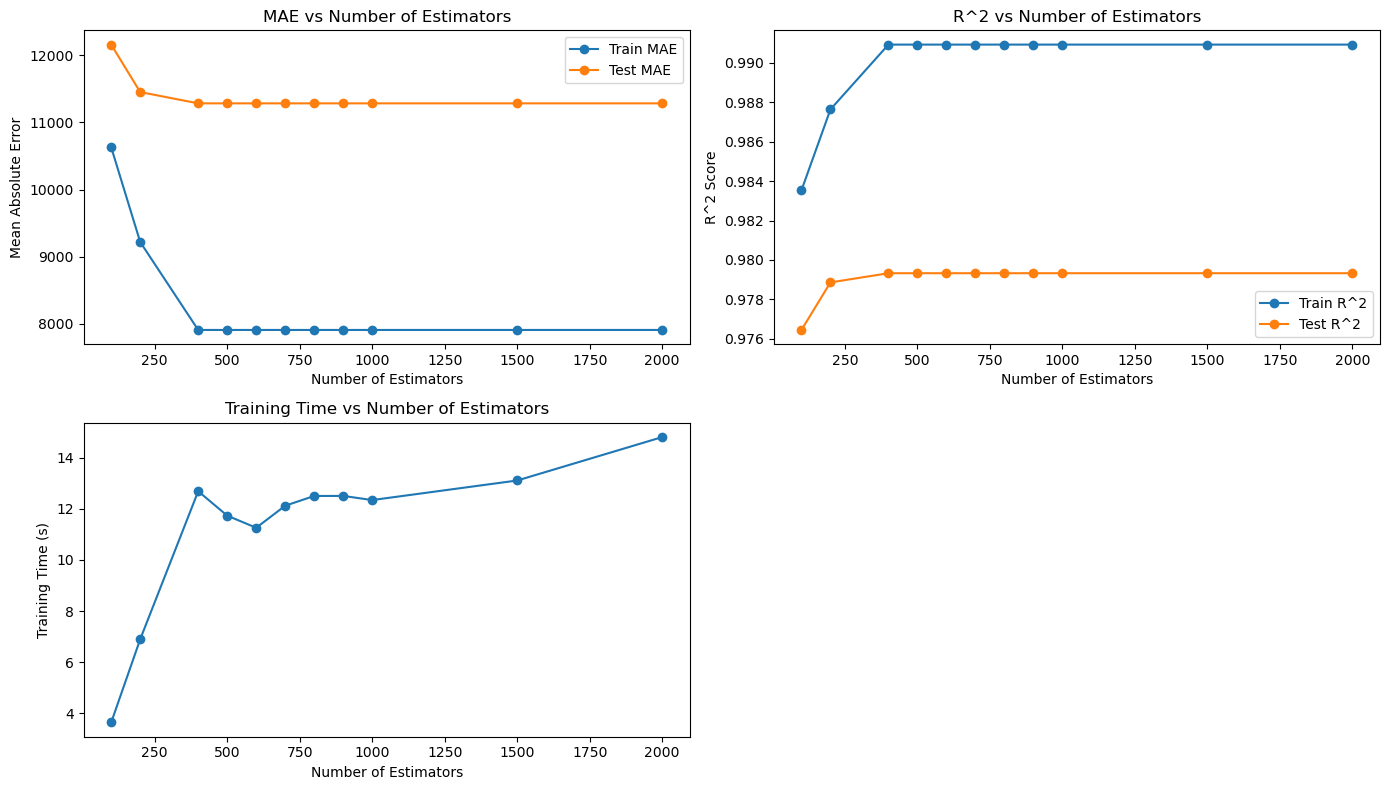

In [127]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = [100, 200, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]
results = []
learned_models = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train,
        eval_metric="rmse",
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
        early_stopping_rounds=20
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    
    learned_models.append(model)

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

    n_estimators     train_mae      test_mae  train_r2   test_r2       time
0            100  10629.894520  12159.946824  0.983527  0.976455   2.449444
1            200   9219.118581  11453.083791  0.987630  0.978864   4.444106
2            400   7819.524938  11282.954937  0.991114  0.979323   8.806432
3            500   7305.275378  11298.445397  0.992242  0.979258   9.656156
4            600   6824.314391  11333.325501  0.993224  0.979116  11.787452
5            700   6419.765181  11369.618843  0.993979  0.978977  14.619872
6            800   6056.792610  11410.857240  0.994620  0.978817  16.291398
7            900   5716.836006  11454.328009  0.995189  0.978653  18.934325
8           1000   5413.417600  11503.053457  0.995671  0.978487  22.067705
9           1500   4241.467270  11717.817429  0.997255  0.977776  34.142800
10          2000   3464.862605  11882.480951  0.998082  0.977261  43.203235


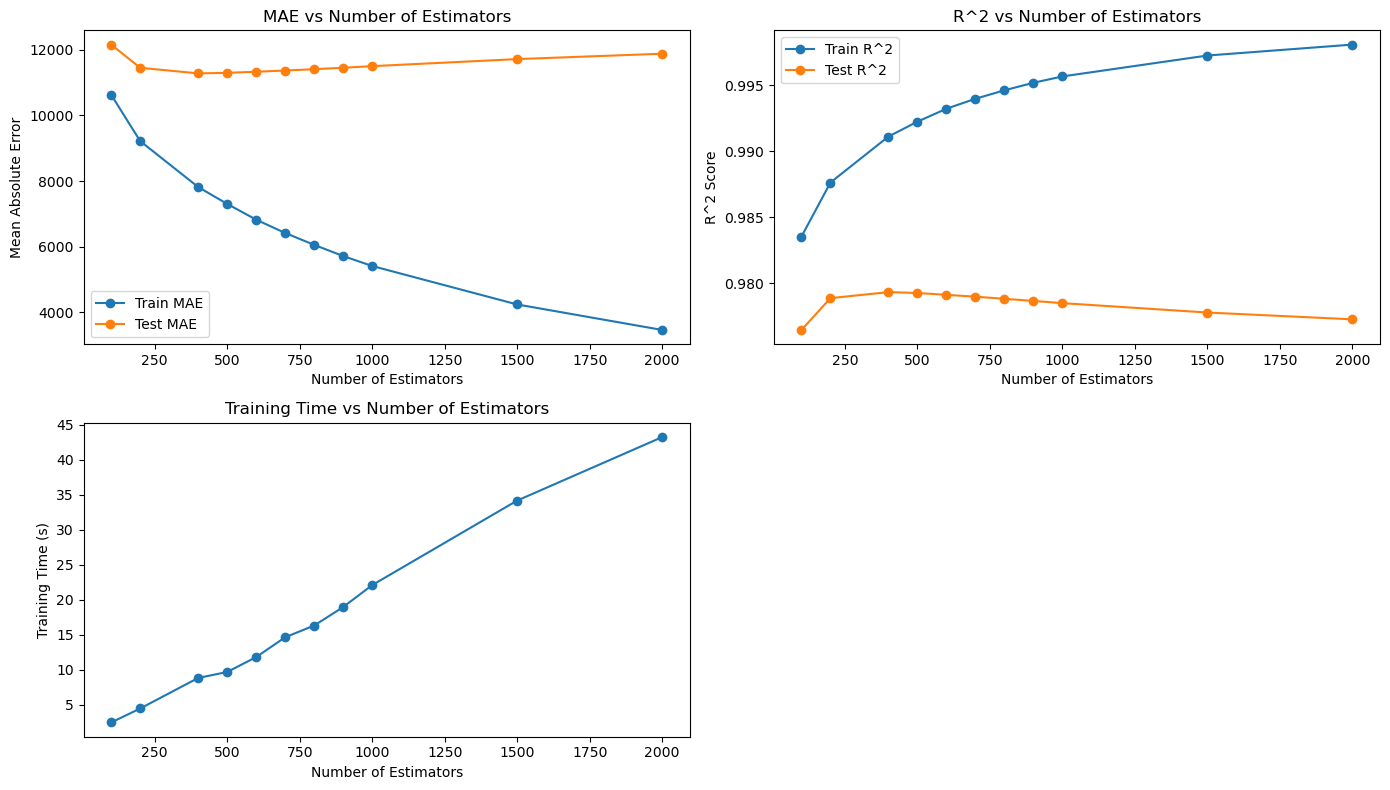

In [128]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = [100, 200, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]
results = []
learned_models = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    
    learned_models.append(model)

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

In [19]:
# sub = pd.DataFrame({
#     "house_id" : X_train.index,
#     "price":y_pred_train
# })

# sub.to_csv('override_xgb_sub.csv', index = False)

# pickle.dump(y_pred_train, open('Data/xgb_train.pickle','wb'))
# pickle.dump(y_pred_test, open('Data/xgb_test.pickle','wb'))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

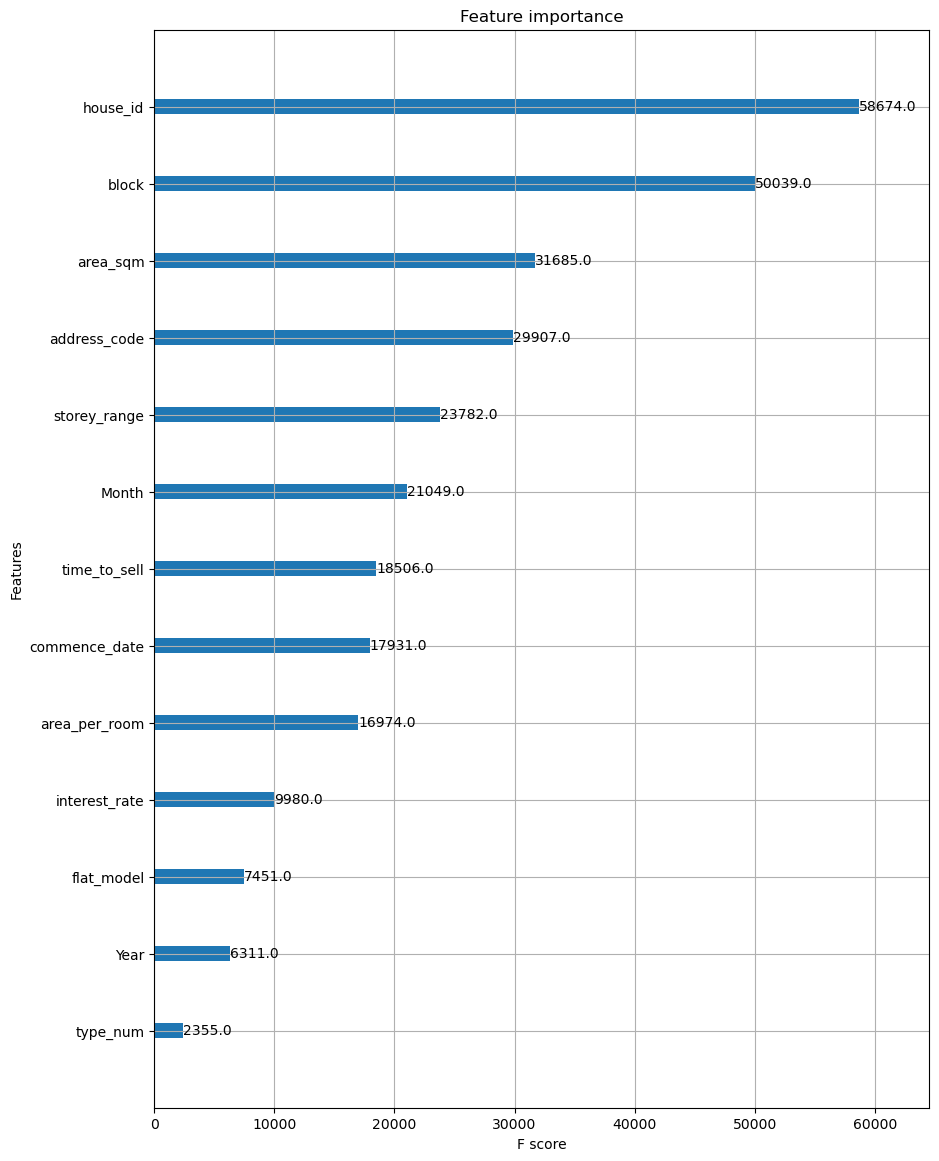

In [20]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [21]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-12152.61915717 -12181.04448335 -12173.76192384 -12089.24234117
 -12156.3782772 ]
교차 검증 MAE 점수: [12152.61915717 12181.04448335 12173.76192384 12089.24234117
 12156.3782772 ]
평균 MAE: 12150.609236545712
표준 편차: 32.45171377911602


In [22]:
### n_estimators=2000인 모델)을 다시 평가
# 모델 훈련 및 예측
model.fit(X_train, y_train) #이 코드 블록은 첫 번째 코드 블록의 마지막 n_estimators 값(2000)으로 모델을 학습시키고, 최종 성능을 평가
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 3545.2218508763326, Train R^2: 0.9980070912332223
Test MAE: 11934.007362465787, Test R^2: 0.9770747215424982


In [24]:
model.fit(
        X_train,
        y_train,
        eval_metric="rmse",
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
        early_stopping_rounds=20
    )

c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\CHOI Je Woo\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 7912.118126050169, Train R^2: 0.9909135730715106
Test MAE: 11392.162417733349, Test R^2: 0.9789613742435215


### 점수가 다른 이유
- 점수가 다른 이유는 두 코드 블록에서 평가하는 모델이 다르기 때문입니다. 
- 첫 번째 코드 블록에서는 다양한 n_estimators 값을 사용하여 여러 모델을 학습하고 평가하는 반면, 두 번째 코드 블록에서는 마지막으로 학습된 모델 (즉, n_estimators=2000인 모델)을 다시 평가합니다.

- 아마 hyperparameter값을 지정해주지 않은 차이 때문에 값의 차이가 나는 것으로 추청

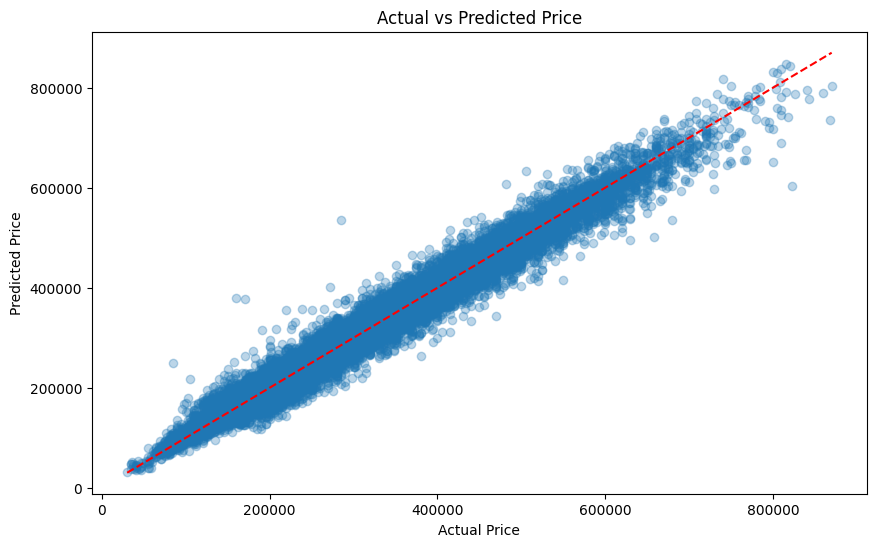

In [23]:
# 실제 값 vs 예측 값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()